  <div style='width: calc(100% - 4rem); font-size: 1.75rem; font-weight: bold; background: darkred;padding: 2rem; border-radius: 1rem; color: white; text-align: center; margin-bottom: 2rem'> Lights, Camera, Data! A Storytelling Approach to Netflix Content! ✨🎥📈</div>

<div style='font-size:1rem; color:#003049'>Netflix has become the leading platform in entertainment, despite the rise of other streaming services, offering a vast and diverse catalog of movies and TV shows, including both third-party content and original productions. Surpassing 300 million subscribers worldwide, Netflix's success is driven by its content strategy, which differentiates it from alternative platforms. Understanding trends in content type and their evolution over time can provide valuable insights into viewer preferences, regional differences, and the strategies behind Netflix's success.<br><br>

This project aims to explore Netflix's content library and its trends over time, from its inception to 2020—just before the impact of COVID-19—using data visualization techniques. These visualizations will help us analyze genre popularity, release trends, top 10 rankings across various categories, and more. We will investigate questions such as:

* How has Netflix and its content library evolved over the years?
* What kind of content can we found on the platform?
* Who are the most prolific directors and creators?

By leveraging Python libraries like Pandas, Matplotlib, and Seaborn, we will transform raw data into engaging, highly customized visual narratives.
</div>

<div style="
    background-color: #FFF0A5; 
    border: 2px solid #F7E38B; 
    border-radius: 5px; 
    padding: 15px; 
    box-shadow: 0 2px 5px rgba(0, 0, 0, 0.1); 
    display: inline-block;
    margin: 5px auto;
">
    If you like my work, please give me an Upvote and comment! 👍 🙏
</div>


In [1]:
# Import python libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from pandas.api.types import CategoricalDtype
from matplotlib.offsetbox import AnchoredText, TextArea, VPacker, HPacker
from matplotlib.offsetbox import AnchoredOffsetbox
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        continue
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

def check_collision(patch1, patch2):
    """
    Check if two FancyBboxPatch instances collide.

    Parameters:
        patch1 (matplotlib.patches.FancyBboxPatch): First patch.
        patch2 (matplotlib.patches.FancyBboxPatch): Second patch.

    Returns:
        bool: True if the patches collide, False otherwise.
    """
    # Get the bounding boxes of the two patches
    bbox1 = patch1.get_extents()
    bbox2 = patch2.get_extents()

    # Check for overlap
    return not (
        bbox1.xmax < bbox2.xmin or  # Patch1 is to the left of Patch2
        bbox1.xmin > bbox2.xmax or  # Patch1 is to the right of Patch2
        bbox1.ymax < bbox2.ymin or  # Patch1 is below Patch2
        bbox1.ymin > bbox2.ymax     # Patch1 is above Patch2
    )

netflix_data = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')
netflix_data['date_added'] = pd.to_datetime(netflix_data.date_added, format='mixed')

# Insert NULL Values
netflix_data.loc[[5541, 5794, 5813], 'duration'] = ['74 min', '84 min', '66 min']
netflix_data.loc[[5989, 6827, 7312, 7537], 'rating'] = ['TV-PG', 'TV-14', 'TV-G', 'PG-13']
netflix_data.loc[[5541, 5794, 5813], 'rating'] = ['TV-MA', 'TV-MA', 'TV-MA']
netflix_data['rating'] = netflix_data['rating'].str.replace('-FV', '').str.replace('UR', 'NR')


# Correcting country names
netflix_data['country'] = netflix_data['country'].str.replace('United States', 'United States of America')
netflix_data['country'] = netflix_data['country'].str.replace('United Kingdom', 'U.K. of Great Britain and Northern Ireland')
netflix_data['country'] = netflix_data['country'].str.replace('South Korea', 'Republic of Korea')
netflix_data['country'] = netflix_data['country'].str.replace('Russia', 'Russian Federation')
netflix_data['country'] = netflix_data['country'].str.replace('Iran', 'Iran (Islamic Republic of)')
netflix_data['country'] = netflix_data['country'].str.replace('West Germany', 'Germany')
netflix_data['country'] = netflix_data['country'].str.replace('Syria', 'Syrian Arab Republic')
netflix_data['country'] = netflix_data['country'].str.replace('Vatican City', 'Holy See')
netflix_data['country'] = netflix_data['country'].str.replace('East Germany', 'Germany')
netflix_data['country'] = netflix_data['country'].str.replace('Palestine', 'West Bank')
netflix_data['country'] = netflix_data['country'].str.replace('Soviet Union', 'Russian Federation')

# Convert to category dtypes
netflix_data['rating'] = netflix_data['rating'].astype('category')
netflix_data['rating'] = pd.Categorical(
    netflix_data['rating'],
    categories=['TV-Y', 'TV-Y7', 'G', 'TV-G', 'PG', 'TV-PG', 'PG-13', 'TV-14', 'R', 'TV-MA', 'NC-17', 'NR'],
    ordered=True    
)
netflix_data['rating_classes'] = netflix_data.rating.cat.rename_categories({
    'TV-Y': 'Kids1',
    'TV-Y7': 'Kids2',
    'G': 'Kids3',
    'TV-G': 'Kids4',
    'PG': 'Kids5',
    'TV-PG': 'Kids6',
    'PG-13': 'Teens7',
    'TV-14': 'Teens8',
    'R': 'Adults9',
    'TV-MA': 'Adults0',
    'NC-17': 'Adultsa',
}).str[:-1]

In [2]:
import requests
import os
import geopandas as gpd 
import zipfile

os.makedirs('/kaggle/temp', exist_ok=True)

url_shapefile = 'https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/world-administrative-boundaries/exports/shp?lang=en&timezone=America%2FGuatemala'
path_shapefile_zip  = '/kaggle/temp/world_shapefile.zip'
path_shapefile_content = '/kaggle/temp/world_shapefile'

downloaded_content = requests.get(url_shapefile).content
with open(path_shapefile_zip, 'wb') as f:
    f.write(downloaded_content)

os.makedirs(path_shapefile_content, exist_ok=True)
with zipfile.ZipFile(path_shapefile_zip) as zip_file:
    zip_file.extractall(path_shapefile_content)

shapefile_path = os.path.join(path_shapefile_content, 'ne_110m_admin_0_countries.shp')
gdf_world = gpd.read_file(path_shapefile_content)

# <div style='color: #8B0000; font-size:2rem'>➡︎ Introduction</div>

## <div style='color: #8B0000'> Netflix Through Time: From Small Company to Global Phenomenon</div>

<div style='font-size:1.1rem; color:#003049'>
<b style='font-weight: bold; color: darkred'>Netflix was created in 1997 </b> by Reed Hastings and Marc Randolph, born out of frustration with late fees at their local video store. Initially, <b style='font-weight: bold; color: darkred'>it was founded as a novel concept – a mail-order DVD rental service</b> where customers could subscribe and receive DVDs by mail, revolutionizing how people accessed movies.
<br><br>
Despite criticism from many people and its competitors, Netflix gained traction, leveraging the internet to build a user-friendly platform and a recommendation system based on customer ratings and viewing history, surpassing 1 million subscribers in 2003
</div>

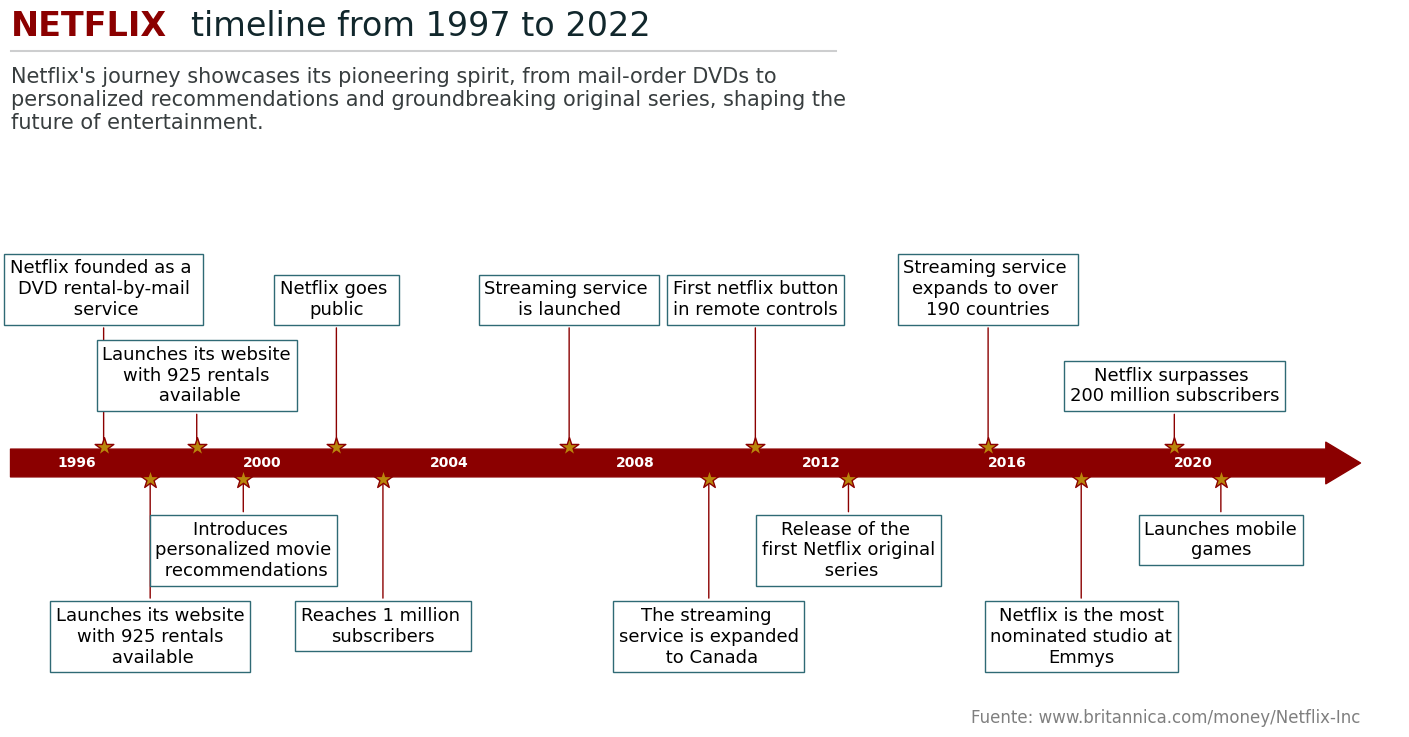

In [3]:
 fig, ax = plt.subplots(figsize=(15, 8))
fig.subplots_adjust(top=0.6, bottom=0.15, left=0.05, right=0.95)
fig.text(s='NETFLIX', x=0.05, y=0.9, ha='left', va='bottom', fontsize=24, fontweight='bold', color='darkred')
fig.text(s='timeline from 1997 to 2022', x=0.17, y=0.90, ha='left', va='bottom', fontsize=24, color='#11272C')
fig.add_artist(plt.Line2D([0.05, 0.6], [0.89, 0.89], color='#060D0F', alpha=0.2))
fig.text(
s="""Netflix's journey showcases its pioneering spirit, from mail-order DVDs to 
personalized recommendations and groundbreaking original series, shaping the
future of entertainment.""", x=.05, y=0.87, ha='left', va='top', fontsize=15, color='#060D0F', alpha=0.8
)

# Timeline data to plot
timeline = {
    1997: 'Netflix founded as a \nDVD rental-by-mail\n service',
    1998: 'Launches its website\nwith 925 rentals\n available',
    1999: 'Launches its website\nwith 925 rentals\n available',
    2000: 'Introduces \npersonalized movie\n recommendations',
    2002: 'Netflix goes \npublic',
    2003: 'Reaches 1 million \nsubscribers',
    2007: 'Streaming service \nis launched',
    2010: 'The streaming \nservice is expanded\n to Canada',
    2011: 'First netflix button\nin remote controls',
    2013: 'Release of the \nfirst Netflix original\n series',
    2016: 'Streaming service \nexpands to over \n190 countries',
    2018: 'Netflix is the most\nnominated studio at\nEmmys',
    2020: 'Netflix surpasses \n200 million subscribers',
    2021: 'Launches mobile\ngames'
}
    
years, facts = list(timeline.keys()), list(timeline.values())

# Add main arrow for timeline
ax.set(ylim=(-1, 1), xlim=(min(years)-2, max(years)+3))
arrow = ax.annotate(
    '', xy=(ax.get_xlim()[1], 0), xytext=(ax.get_xlim()[0], 0),
    arrowprops={'facecolor': 'darkred', 'edgecolor':'darkred', 'width': 20, 'headwidth': 30, 'headlength': 25, 'linewidth': 1, 'zorder':0}
)

# Add an annotation for each timeline item
annotations = []
for i in range(len(years)):
    year, fact = years[i], facts[i]
    yi = 0.8 if (i % 2 == 0) else - 0.8
    va = 'bottom' if (i % 2 == 0) else 'top'
    annot = ax.annotate(
        fact, 
        fontsize=13,
        xy=(year, 0),
        xytext=(year, yi),
        arrowprops={'arrowstyle': '-', 'color':'darkred'},
        ha='center', va=va,
        bbox={'facecolor':'white', 'edgecolor':'#2F6A75', 'alpha': 1}
    )
    annotations.append(annot)
    ax.scatter(
        [year], 
        [0.09 if va == 'bottom' else -0.09], 
        marker='*' if va == 'bottom' else '*',
        color='#B9860C',
        s=200,
        zorder=15,
        edgecolor='darkred'
    )

# Change xticklabels for custom label annotations on the timeline arrow
ax.xaxis.set_major_locator(plt.MultipleLocator(4))
for label in ax.get_xticklabels():
    pos = label.get_position()
    if not (ax.get_xlim()[0] <= pos[0] <= ax.get_xlim()[1]):
        continue
    text = label.get_text()
    ax.text(
        s=text, x=pos[0], y=0,
        va='center', 
        fontsize=10, 
        fontweight='bold',
        color='white'
    )
ax.axis('off')

# Repositions the colliding annotations.
fig.canvas.draw()
for i in range(1, len(annotations)):
    for j in range(i):
        collision = check_collision(
            annotations[i].get_bbox_patch(),
            annotations[j].get_bbox_patch()
        )
        if collision:
            posi = annotations[i].get_position()
            annotations[i].set_y(posi[1]*0.4)
            fig.canvas.draw()

fig.text(s='Fuente: www.britannica.com/money/Netflix-Inc', x=0.95, y=0.05, ha='right', 
         fontsize=12, alpha=0.5);

<div style='font-size:1.1rem; color:#003049'>
Around 2007, Netflix began evolving, <b style='font-weight: bold; color: darkred'>transitioning from its DVD-by-mail service to a streaming platform</b> that provided instant access to hundreds of movies and TV shows directly on the internet. This shift proved pivotal, marking a turning point in how entertainment was consumed.
<br><br>
Netflix expanded its global reach significantly, <b style='font-weight: bold; color: darkred'>achieving availability in over 190 countries by January 2016 </b>, and experiencing substantial subscriber growth. The company strengthened its position by investing heavily in original content, producing critically acclaimed series such as 'House of Cards' and 'Stranger Things,' which contributed significantly to its subscriber base. Notably, <b style='font-weight: bold; color: darkred'>'Club de Cuervos,' released in 2015</b>, marked a pivotal moment as Netflix's first Spanish-language original series, paving the way for the platform's extensive expansion into international content production.
<br><br>
Netflix achieved a major milestone in 2019, reaching 200 million subscribers, and continued its growth trajectory, <b style='font-weight: bold; color: darkred'>surpassing 300 million subscribers in 2024</b>. Despite the emergence of strong competitors like Disney+, HBO Max, and Amazon Prime Video, Netflix remains a leading streaming platform.
</div>

# <div style='color: #8B0000; font-size:2rem'>➡︎  Evolution of Netflix content over time</div>

<div style='font-size:1.1rem; color:#003049'>
Netflix's transition from DVD rentals to streaming was a complex and slow. Initially, the company relied heavily on licensed content from major studios, <b style='font-weight: bold; color: darkred'>but many producers were skeptical about the viability of the emerging streaming model </b>. 
<br><br>
The turning point came around 2015, when <b style='font-weight: bold; color: darkred'>Netflix began investing aggressively in original programming</b>. The massive success of series like House of Cards, Orange Is the New Black, and Stranger Things solidified the company’s reputation as a content powerhouse, reducing its dependence on third-party licenses. <b style='font-weight: bold; color: darkred'>By 2019, Netflix was at its peak in content additions</b>, having expanded its original productions globally and securing a dominant position in the streaming market.
</div>

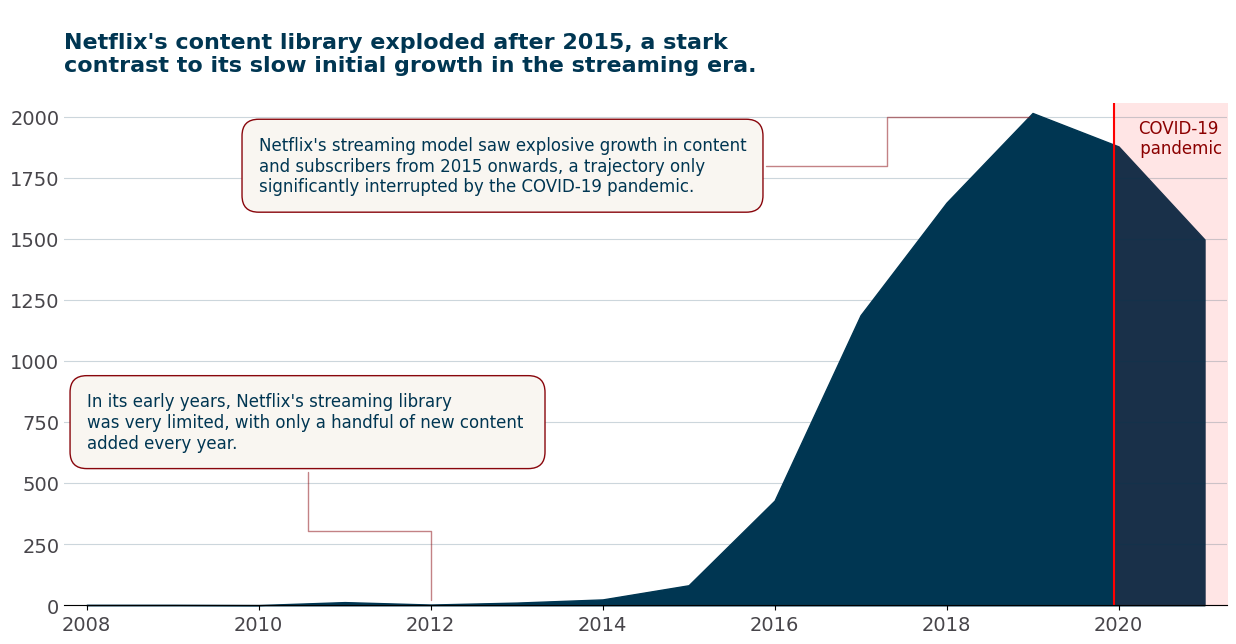

In [4]:
# Content over time plot
monthly_added = netflix_data.date_added.dropna().sort_values().dt.strftime('%Y-%m').value_counts(sort=False)
yearly_added = netflix_data.date_added.dropna().sort_values().dt.year.value_counts(sort=False)

fig, ax = plt.subplots(figsize=(15, 8))
fig.subplots_adjust(top=0.75)
ax.margins(0.02)
ax.fill_between(yearly_added.index, yearly_added, color='#003652', alpha=1)

ax.spines[['top', 'right',]].set_visible(False)
ax.spines['bottom'].set(position='zero')
ax.spines.left.set_visible(False)
ax.tick_params(axis='y', length=0)

ax.grid(axis='y', color='#003652', alpha=0.2, zorder=0)
ax.tick_params(labelcolor='#47454A', labelsize=14)

ax.set_title(
    '\nNetflix\'s content library exploded after 2015, a stark \n' \
    'contrast to its slow initial growth in the streaming era.\n', 
    loc='left', fontsize=16, color='#003652', fontweight='bold')

bbox = {
    'edgecolor': '#89060C',
    'facecolor': '#F9F6F1',
    'boxstyle': 'round,pad=1',
}
arrow = {
    'arrowstyle': '-',
    'connectionstyle': 'bar,angle=180,fraction=0.5',
    'edgecolor': '#89060C',
    'alpha': 0.5
}

text1 = \
"""In its early years, Netflix's streaming library 
was very limited, with only a handful of new content 
added every year."""
ax.annotate(text1, xy=(2012, 10), xytext=(2008, 750), 
            color='#003652', bbox=bbox, va='center', arrowprops=arrow, 
            fontsize=12);

arrow = {
    'arrowstyle': '-',
    'connectionstyle': 'bar,angle=90,fraction=-0.5',
    'edgecolor': '#89060C',
    'alpha': 0.5,
    'relpos': (1, 0.5)
}

text1 = \
"""Netflix's streaming model saw explosive growth in content
and subscribers from 2015 onwards, a trajectory only 
significantly interrupted by the COVID-19 pandemic."""
ax.annotate(text1, xy=(2019, 2000), xytext=(2010, 1800), 
            color='#003652', bbox=bbox, va='center', arrowprops=arrow, 
            fontsize=12);

ax.axis(ax.axis())
ax.vlines([2019.95], ymin=0, ymax=2200, color='red')
ax.fill_between([2019.95, 2024], [2200, 2200], color='red', alpha=0.1)
ax.text(s='COVID-19\n pandemic', x=2020.7, y=1850, ha='center', fontsize=12, color='darkred');


<div style='font-size:1.1rem; color:#003049'>
<br>
However, <b style='font-weight: bold; color: darkred'>the COVID-19 pandemic in 2020 introduced new challenges</b>. While lockdowns led to an explosion in streaming demand, production shutdowns and theater closures disrupted content pipelines. The industry landscape shifted further as <b style='font-weight: bold; color: darkred'>competitors like Disney+, HBO Max, and Apple TV+ entered the streaming race</b>, intensifying the battle for subscriber retention and exclusive content.
<br>

<div style='font-size:1.1rem; color:#003049'>
<br>
In its early stages, Netflix primarily featured US-produced content. A significant strategic shift occurred after 2015, leading to a substantial increase in international productions.  Although the US still contributes the most content, <b style='font-weight: bold; color: darkred'>international titles now account for 68% of the total: more than two-thirds of Netflix's offerings</b>.
<br>

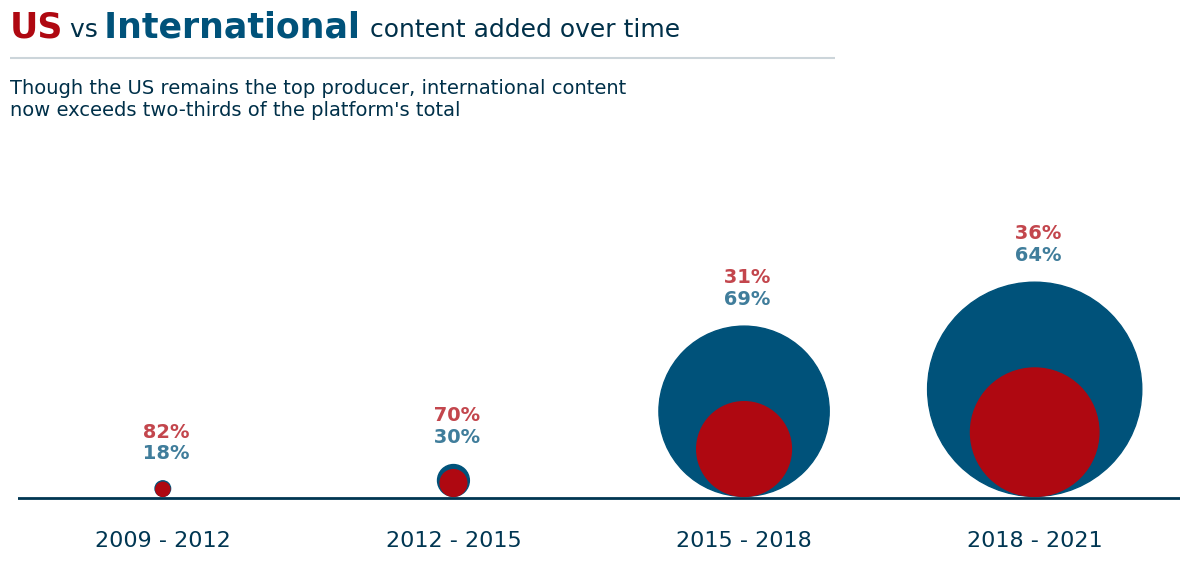

In [5]:
# Content grow: US vs International

total_us = netflix_data[netflix_data.country=='United States of America'].dropna().date_added.dt.year
total_int = netflix_data[netflix_data.country!='United States of America'].dropna().date_added.dt.year
total_us = pd.cut(total_us, bins=(2009, 2012, 2015, 2018, 2021)).value_counts()
total_int = pd.cut(total_int, bins=(2009, 2012, 2015, 2018, 2021)).value_counts()

fig, ax = plt.subplots(1, 4, figsize=(15, 7), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, top=0.75)
axt = fig.add_axes([.12, .73, 0.55, 0.2])
axt.axhline(0.7, color='#003049', alpha=0.2)
axt.text(s='Though the US remains the top producer, international content\n'
           'now exceeds two-thirds of the platform\'s total', 
        x=0, y=0.55, fontsize=14, color='#003049', ha='left', va='top')
axt.axis('off')

fig.text(x=0.12, y=0.9, s='US', fontsize=25, ha='left', fontweight='bold', color='#AF0811')
fig.text(x=0.155, y=0.9, s=' vs ',  fontsize=18, ha='left', fontweight='regular', color='#003049')
fig.text(x=0.175, y=0.9, s=' International', fontsize=25, ha='left', fontweight='bold', color='#00527A')
fig.text(x=0.355, y=0.9, s=' content added over time',  fontsize=18, ha='left', fontweight='regular', color='#003049')

for axi, area_us, area_int, interval in zip(ax[::-1], total_us, total_int, total_us.index):
    radius_tot = 0.13 * np.sqrt(area_us + area_int)
    radius_int = 0.13 * np.sqrt(area_us)
    pct_us = 100 * area_us / (area_us + area_int)
    pct_int = 100 * area_int / (area_us + area_int)
    
    circle = plt.Circle((0, radius_tot), radius_tot, color='#00527A')  
    circle_int = plt.Circle((0, radius_int), radius_int, color='#AF0811')

    axi.annotate(f' {pct_us:.0f}%', color='#AF0811', xy=(0, 2*radius_tot+3), 
                 fontweight='bold', ha='center', fontsize=14, alpha=0.75)
    axi.annotate(f' {pct_int:.0f}%', color='#00527A', xy=(0, 2*radius_tot+1.5),
                 fontweight='bold', ha='center', fontsize=14, alpha=0.75)
    
    axi.add_patch(circle)
    axi.add_patch(circle_int)
    axi.set_aspect('equal')
    axi.set(xlim=(-10, 10), ylim=(-2, 20)) # Ajuste del ylim para que los circulos se vean completos
    axi.set_xlabel(f'{interval.left} - {interval.right}', color='#003652', fontweight='regular', fontsize=16)
    axi.axhline(-0.1,  linewidth=2, color='#003652') # Agregar una linea horizontal en 0 para visualizacion
    axi.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    axi.set(xticks=[], yticks=[])

plt.show()



<div style='font-size:1.1rem; color:#003049'>
<br>
<b style='font-weight: bold; color: darkred'>Netflix's content is truly global, with productions originating from over 100 countries around the world </b>.The United States leads by a large margin, contributing nearly 3,700 titles to the platform. However, countries like India, the United Kingdom, Canada, and France also make significant contributions, <b style='font-weight: bold; color: darkred'>highlighting Netflix’s diverse and international content strategy </b>. This diversity reflects the platform’s effort to appeal to a wide audience by embracing regional storytelling and local talent.

</div>

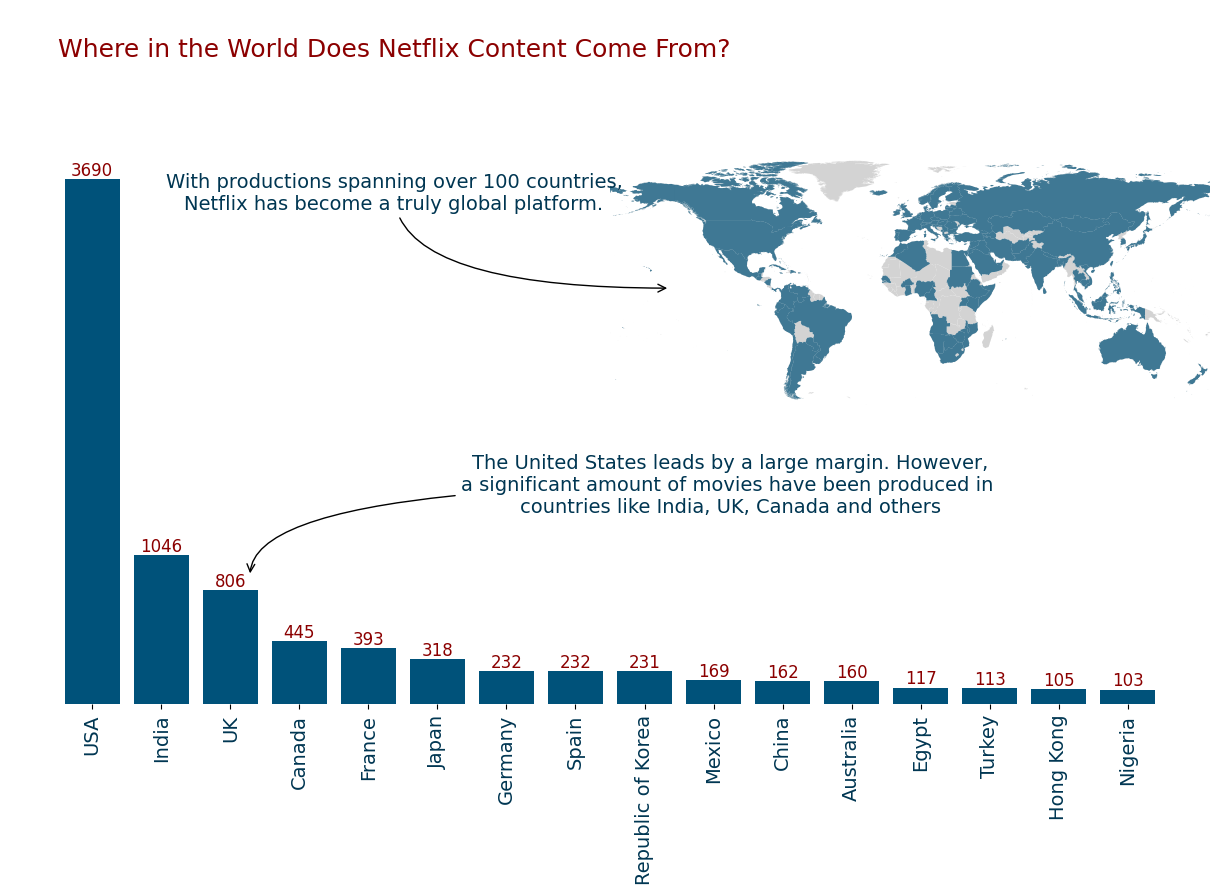

In [6]:

conteo_paises = (
    netflix_data['country'].str.split(', ')
    .explode()
    .str.replace(',', '')
    .str.strip()
    .value_counts()
    .reset_index(drop=False)
)

merged_gdf = gdf_world.merge(
    conteo_paises,
    how='right',
    left_on='name', 
    right_on='country'
)

fig = plt.figure(figsize=(15, 8))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax = fig.add_axes([0.5, 0.4, 0.4, 0.4])

ax2.axis('off');ax.axis('off')

gdf_world.plot(color='lightgray', ax=ax)
merged_gdf[merged_gdf['count']>0].plot(ax=ax, color='#00527A', alpha=0.7)

ax.set_ylim(-90, 90)
ax.set_xlim(-180, 180)


ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.8], facecolor='none')
xlabels = (conteo_paises.loc[:15]['country']
           .str.replace('United States of America', 'USA')
           .str.replace('U.K. of Great Britain and Northern Ireland', 'UK')
          )

bars = ax2.bar(
    xlabels,
    conteo_paises.loc[:15]['count'],
    color='#00527A',
)
ax2.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
ax2.set_yticks([])
ax2.tick_params(rotation=90, axis='x', labelsize=14, labelcolor='#003652')

ax2.bar_label(bars, color='darkred', fontsize=12)
ax2.set_ylim(0, 4500)

ax2.annotate(
    'With productions spanning over 100 countries,' 
    '\nNetflix has become a truly global platform.',
    xy=(0.55, 0.65),
    xytext=(0.32, 0.8),
    ha='center', va='center',
    xycoords='axes fraction',
    arrowprops={'arrowstyle': '->',
                'connectionstyle': 'angle3,angleA=-90,angleB=0'},
    fontsize=14, color='#003652'
)

ax2.annotate(
    'The United States leads by a large margin. However,\n'
    'a significant amount of movies have been produced in \n'
    'countries like India, UK, Canada and others',
    xytext=(0.6, 0.3),
    xy=(0.2, 0.2),
    xycoords='axes fraction',
    ha='center',
    arrowprops={'arrowstyle': '->',
                'connectionstyle': 'angle3,angleA=-180,angleB=-90'},
    fontsize=14, color='#003652'
    
)

ax2.set_title('\n      Where in the World Does Netflix Content Come From?', loc='left', 
              fontsize=18, color='darkred');


# <div style='color: #8B0000; font-size:2rem'>➡︎  What's Streaming: A Look at Content Types</div>

<div style='font-size:1.1rem; color:#003049'>
Netflix boasts a diverse library catering to a global audience, with a significant portion dedicated to two primary content types: movies and TV shows. As the accompanying visual illustrates, <b style='font-weight: bold; color: darkred'> movies constitute the larger share of individual titles, representing approximately 69.6% of the total catalog (6131 titles). In contrast, TV shows make up the remaining 30.4% (2676 titles).</b>
<br><br>
However, a closer look reveals a different perspective when considering the sheer volume of content. While movies may be more numerous as individual entries, TV shows often encompass multiple seasons, each containing several episodes. To illustrate this, considering an estimated average of 10 episodes per season and an average episode duration of 25 minutes, the total viewing time offered by TV shows significantly outweighs that of movies. The graphic indicates a total of <b style='font-weight: bold; color: darkred'> 1.417 million minutes of content for TV shows compared to 610,000 minutes for movies </b>.

</div>


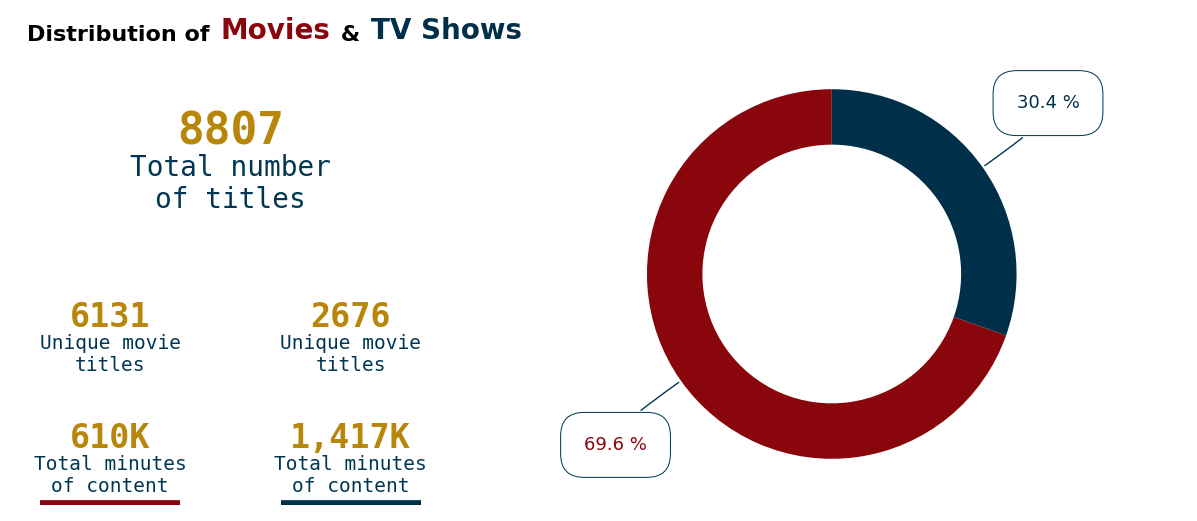

In [7]:

n_titles = len(netflix_data)
n_movies = len(netflix_data[netflix_data.type=='Movie'])
n_tv_shows = len(netflix_data[netflix_data.type=='TV Show'])
min_movies = (
    netflix_data.query('type == "Movie"')
    .duration
    .str.extract('(\d+)')
    .astype(float)
    .sum()
    .values[0]
)
min_tv_shows = 10 * 30 * (
    netflix_data.query('type == "TV Show"')
    .duration
    .str.extract('(\d+)')
    .astype(float)
    .sum()
    .values[0]
)
min_total = min_movies + min_tv_shows

gs = plt.GridSpec(4, 5)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(gs[:2, :2])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[2, 1])
ax4 = fig.add_subplot(gs[3, 0])
ax5 = fig.add_subplot(gs[3, 1])
ax = fig.add_subplot(gs[:, 2:])

# Plot texts
ax1.annotate(str(n_titles), xy=(0.5, 0.5),
             color='#B9860C',
             fontsize=32,
             fontweight='bold',
             fontfamily='monospace',
             ha='center',
             va='bottom'
)
ax1.annotate("Total number\nof titles",
             xy=(0.5, 0.5),
             color='#003652',
             fontsize=20, 
             fontweight='light', 
             fontfamily='monospace',
             ha='center',
             va='top')


ax2.annotate(str(n_movies),
             xy=(0.5, 0.5),
             color='#B9860C',
             fontweight='bold',
             fontfamily='monospace',
             ha='center',
             va='bottom',
             fontsize=24)
ax2.annotate('Unique movie\ntitles',
             xy=(0.5, 0.5),
             color='#003652',
             fontweight='light', 
             fontfamily='monospace', 
             ha='center', 
             va='top',
             fontsize=14)
ax4.annotate(f'{min_movies/1000:,.0f}K',
             xy=(0.5, 0.5),
             color='#B9860C',
             fontweight='bold',
             fontfamily='monospace',
             ha='center',
             va='bottom',
             fontsize=24)
ax4.annotate('Total minutes\nof content',
             xy=(0.5, 0.5),
             color='#003652',
             fontweight='light', 
             fontfamily='monospace', 
             ha='center', 
             va='top',
             fontsize=14)

ax3.annotate(str(n_tv_shows),
             xy=(0.5, 0.5),
             color='#B9860C',
             fontweight='bold',
             fontfamily='monospace',
             ha='center',
             va='bottom',
             fontsize=24)
ax3.annotate('Unique movie\ntitles',
             xy=(0.5, 0.5),
             color='#003652',
             fontweight='light', 
             fontfamily='monospace', 
             ha='center', 
             va='top',
             fontsize=14)
ax5.annotate(f'{min_tv_shows/1000:,.0f}K',
             xy=(0.5, 0.5),
             color='#B9860C',
             fontweight='bold',
             fontfamily='monospace',
             ha='center',
             va='bottom',
             fontsize=24)
ax5.annotate('Total minutes\nof content',
             xy=(0.5, 0.5),
             color='#003652',
             fontweight='light', 
             fontfamily='monospace', 
             ha='center', 
             va='top',
             fontsize=14)



# Crear el gráfico de pastel
pie_values = netflix_data.type.value_counts()
pcts = pie_values / sum(pie_values)

wedges, _ = ax.pie(
            pie_values,
            colors=['#89060C', '#003049'],
            startangle=90,         # Hace que empiece desde arriba
            wedgeprops={'width': 0.3},  # Controla el grosor del doughnut
            labels=None,           # Si no quieres que aparezcan las etiquetas en el gráfico
            autopct=None,
            pctdistance=0.75,
            textprops={'color': 'white', 'fontsize': 20})

# Asegurarse de que sea un círculo perfecto
ax.set_aspect('equal')


bbox_props = dict(boxstyle="round,pad=1.3", fc="w", lw=0.72, ec='#003652')
kw = dict(arrowprops=dict(arrowstyle="-", color='#003652'),
          bbox=bbox_props, zorder=0, va="center")


colors=['#89060C', '#003049']
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    ha = {-1: "right", 1: "left"}[int(np.sign(x*0.2))]
    connectionstyle = f"angle3,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(f'{100*pcts.iloc[i]:.1f} %', xy=(x, y), xytext=(np.sign(x), 1.6*y),
                ha=ha, fontsize=13, color=colors[i], **kw,)

for ax in [ax1, ax2, ax3, ax4, ax5, ax]:
    ax.axis('off')
    ax.axis(ax.axis())
    
#ax2.hlines(xmin=0, xmax=1, y=0, color='#89060C', lw=8)
ax4.hlines(xmin=0.15, xmax=0.85, y=0, color='#89060C', lw=7)
#ax3.hlines(xmin=0, xmax=1, y=0, color='#003049', lw=8)
ax5.hlines(xmin=0.15, xmax=0.85, y=0, color='#003049', lw=7)
#ax2.set_title('Movies', loc='center', fontsize=14, color='#89060C')
#ax3.set_title('TV Shows', loc='center', fontsize=14, color='#003049');


text1 = TextArea("Distribution of ", textprops=dict(color='black', fontsize=16, weight='bold'))
text2 = TextArea("Movies", textprops=dict(color='#89060C', fontsize=20, weight='bold'))
text3 = TextArea(" & ", textprops=dict(color='black', fontsize=16, weight='bold'))
text4 = TextArea("TV Shows", textprops=dict(color='#003049', fontsize=20, weight='bold'))

# Combinar horizontalmente
title_box = HPacker(children=[text1, text2, text3, text4], align="left", pad=0, sep=2)

# Anclar arriba del eje
anchored_title = AnchoredOffsetbox(loc='upper center', child=title_box, pad=0.5,
                                   frameon=False, bbox_to_anchor=(0.6, 1.15),
                                   bbox_transform=ax1.transAxes, borderpad=0.0)

axt = fig.add_axes([0.9, 0.1, 0.01, 0.8])
axt.axis('off')
fig.add_artist(anchored_title);

<div style='font-size:1.1rem; color:#003049'>
Therefore, the 'length' comparison between movies and TV shows depends heavily on the metric used – the number of unique titles or the total viewing duration. Both perspectives offer valuable insights into the vastness and composition of Netflix's streaming content. <b style='font-weight: bold; color: darkred'>Regardless of how you measure it, one thing is certain: Netflix offers a substantial amount of content for viewers to explore.</b>
</div>

<div style='font-size:1.1rem; color:#003049'>
Beyond just movies and TV shows, Netflix uses ratings to help viewers know what's right for different ages. Looking at the visuals, we can see how the content is spread out. The donut chart gives us a big picture: <b style='font-weight: bold; color: darkred'> a significant portion of what's on Netflix appears to be rated for 'Adults' (the red segment at 46.0%)</b>, with a notable amount also for <b style='font-weight: bold; color: darkred'>Teens (the orange segment at 30.4%)</b>, and a smaller portion for <b style='font-weight: bold; color: darkred'>Kids (the blue segment at 23.6%)</b>. This suggests a substantial amount of content that isn't specifically aimed at young children.
<br><br>
The bar chart provides more detail, showing how many titles fall under specific ratings like TV-Y and G (mostly for kids), then ratings like PG-13 and TV-14 (often for teens), and finally R and TV-MA (for adults, with TV-MA being the most prevalent category). This detailed breakdown, alongside the donut chart, indicates that while content for younger viewers exists, <b style='font-weight: bold; color: darkred'>the platform leans towards offering a larger selection for older demographics, particularly adults and teenagers.</b>
</div>

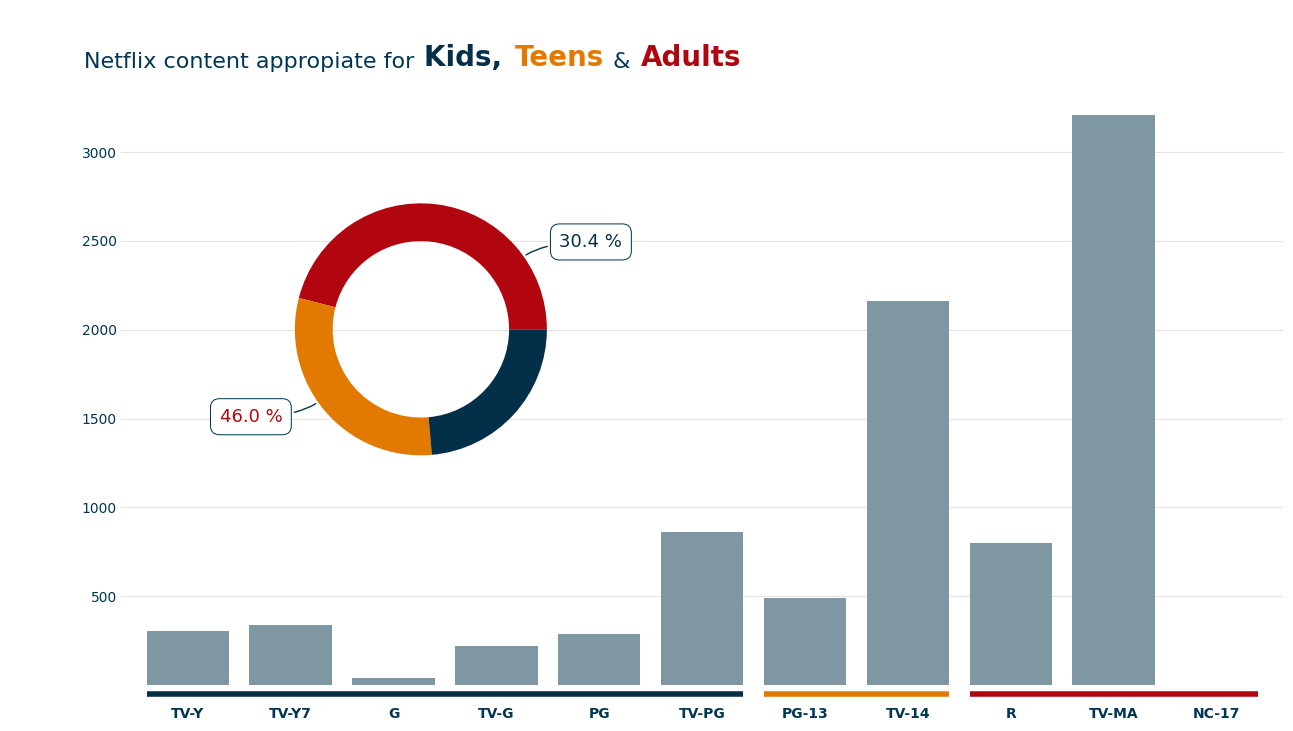

In [8]:

colors = ['#B1060F', '#E27A02', '#032F48']

fig, ax = plt.subplots(figsize=(15, 9))

netflix_data.query('rating != "NR"').rating.value_counts().sort_index().plot(
    kind='bar',
    color='#7F97A3',
    width=0.8,
    ax=ax,
    zorder=6
)

ax.tick_params(
    axis='both',
    rotation=0, 
    direction='in',
    bottom=False,
    left=False,
    pad=3, 
    labelcolor='#003652'
)
ax.set_xticklabels(ax.get_xticklabels(), weight='bold', zorder=15)
ax.set_yticks(ax.get_yticks()[1:-1])
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax.set_xlabel('')
ax.grid(color='#47454A', alpha=0.15, axis='y', zorder=0)
ax.set_ylim(-100, 3800)
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[-1] - 1)


ax.hlines(xmin=-0.4, xmax=5.4, y=-50, lw=4, color=colors[2])
ax.hlines(xmin=5.6, xmax=7.4, y=-50, lw=4, color=colors[1])
ax.hlines(xmin=7.6, xmax=10.4, y=-50, lw=4, color=colors[0])


s="""Netflix offers a diverse library of content, with a strong focus
on mature audiences (TV-MA). This suggests a significant portion of 
Netflix's user base is composed of adults."""



# Plot doughnut chart
ax = fig.add_axes([0.15, 0.35, 0.35, 0.35])
ax.set_aspect('equal')

pie_data = netflix_data.query('rating_classes != "N"')['rating_classes'].value_counts()
pcts = pie_data / pie_data.sum()
wedes, *_ = ax.pie(
    pie_data,
    colors=colors,
    radius=1,
    wedgeprops={'width': 0.3}
)


bbox_props = dict(boxstyle="round,pad=0.5", fc="w", lw=0.72, ec='#003652')
kw = dict(arrowprops=dict(arrowstyle="-", color='#003652'),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    ha = {-1: "right", 1: "left"}[int(np.sign(x*0.2))]
    connectionstyle = f"angle3,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(f'{100*pcts.iloc[i]:.1f} %', xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                ha=ha, fontsize=13, color=colors[-i], **kw,)


# Titlte of tha visualization
#fig.text(s='Netflix content appropiate for ', x=0.5, y=0.92, fontsize=15, ha='center', color='#003652');
text0 = TextArea('Netflix content appropiate for ', 
                 textprops=dict(color='#003652', fontsize=16, fontweight='medium'))
text1 = TextArea("Kids, ", textprops=dict(color=colors[2], fontsize=20, weight='bold'))
text2 = TextArea("Teens", textprops=dict(color=colors[1], fontsize=20, weight='bold'))
text3 = TextArea(" & ", textprops=dict(color='#003652', fontsize=16, weight='medium'))
text4 = TextArea("Adults", textprops=dict(color=colors[0], fontsize=20, weight='bold'))

# Combinar horizontalmente
title_box = HPacker(children=[text0, text1, text2, text3, text4], align="left", pad=0, sep=2)

# Anclar arriba del eje
anchored_title = AnchoredOffsetbox(loc='upper center', child=title_box, pad=0.5,
                                   frameon=False, bbox_to_anchor=(0.51, 1.75),
                                   bbox_transform=ax1.transAxes, borderpad=0.0)
fig.add_artist(anchored_title);

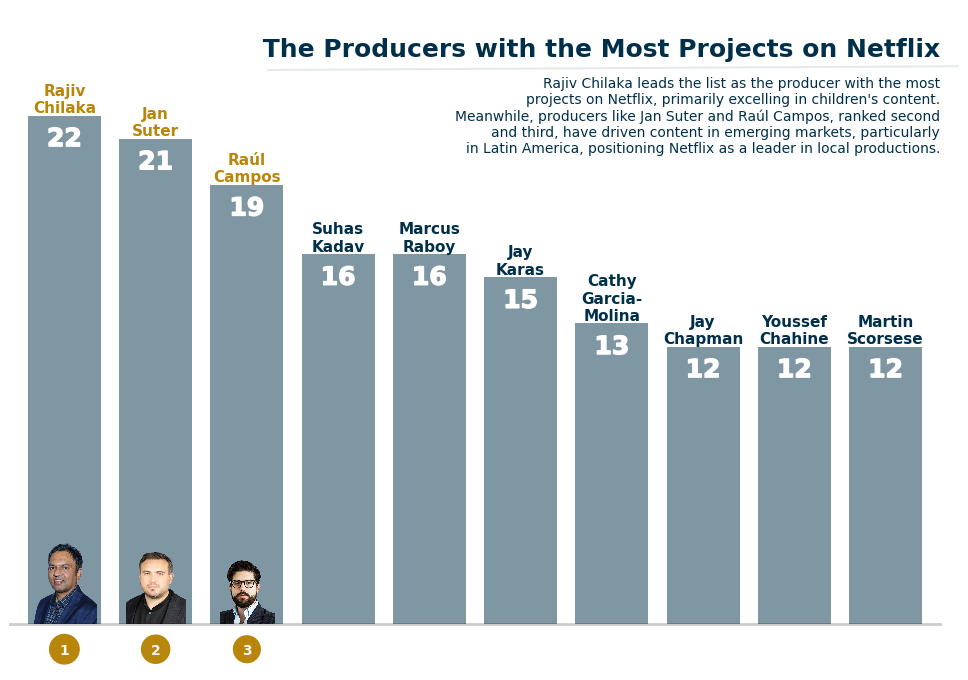

In [9]:
from matplotlib.offsetbox import OffsetImage, OffsetBox
from matplotlib.offsetbox import HPacker
from matplotlib import patheffects


directors = []
for director in netflix_data.director:
    if isinstance(director, str):
        directors.extend(director.split(','))
directors = [director.strip() for director in directors]

top_director = (
    pd.Series(directors)
    .value_counts()
    .head(10)
)
#top_director['...'] = 5
top_director.sort_values(ascending=False, inplace=True)
top_3 = top_director.index[:3]
 
fig, ax = plt.subplots(figsize=(12, 7.5))
ax.margins(0.02)
ax.spines[['left', 'right', 'top']].set_visible(False)
ax.spines['bottom'].set(position='zero', lw=2, zorder=10, alpha=0.2)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks([])
bars = ax.bar(top_director.index, top_director, zorder=5, color='#003049', lw=0.5, alpha=0.5)

# Add images
img1 = OffsetImage(plt.imread('/kaggle/input/netflix-img/rajiv_chilaka.png'), zoom=0.13)
img1_bbox = AnnotationBbox(img1, (0, 0), frameon=False, box_alignment=(0.5, 0), zorder=10)
ax.add_artist(img1_bbox)
img2 = OffsetImage(plt.imread('/kaggle/input/netflix-img/Jan_suter.png'), zoom=0.12)
img2_bbox = AnnotationBbox(img2, (1, 0), frameon=False, box_alignment=(0.5, 0), zorder=10)
ax.add_artist(img2_bbox)
img3 = OffsetImage(plt.imread('/kaggle/input/netflix-img/raul_campos.png'), zoom=0.11)
img3_bbox = AnnotationBbox(img3, (2, 0), frameon=False, box_alignment=(0.5, 0), zorder=10)
ax.add_artist(img3_bbox)

# Add and format labels
for bar, label in zip(bars, top_director.index):
    text_label = label.replace(' ', '\n').replace('-', '-\n') if label != '...' else '•••'
    color = '#B9860C' if label in top_director.index[:3] else '#003049'
    ax.annotate(
        text_label,
        xy = (bar.get_x() + bar.get_width()/2, bar.get_height()),
        ha='center', va='bottom',
        color=color,
        fontsize=11 if label!='...' else 15,
        fontweight='600'
    )
    t=ax.annotate(
        bar.get_height() if label!='...' else '',
        xy= (bar.get_x() + bar.get_width()/2, bar.get_height()-0.5),
        ha='center', va='top',
        fontsize=18,
        color='#FFFFFF',
        fontweight='bold',
        alpha=1,
        path_effects=[patheffects.withStroke(linewidth=1, foreground='white')],
        zorder=50
    )


#bars[-1].remove()

# Add red circles
ax.scatter(
    ['Rajiv Chilaka', 'Jan Suter', 'Raúl Campos'],
    [-1.1, -1.1, -1.1], 
    marker='o',
    s=[450, 410, 370],
    color='#B9860C'
)

ax.set_ylim(-2, 23)
for i, label in enumerate(top_3):
    ax.annotate(i+1, xy=(label, -1.15), color='#F5F5F1', ha='center', va='center', 
                fontweight='bold')

ax.set_title('\n The Producers with the Most Projects on Netflix\n', loc='right', fontsize=18, color='#003049', fontweight='bold');
fig.text(
s="""Rajiv Chilaka leads the list as the producer with the most
projects on Netflix, primarily excelling in children's content.
Meanwhile, producers like Jan Suter and Raúl Campos, ranked second
and third, have driven content in emerging markets, particularly
in Latin America, positioning Netflix as a leader in local productions.""", x=0.9, y=0.8, ha='right', color='#003049')

line = plt.Line2D([0.34, 0.915], [0.91, 0.915], color='#003049', alpha=0.1)
fig.add_artist(line);